<a href="https://colab.research.google.com/github/risa1796/EDA-ML-exercises/blob/main/OKCupid_UserSegmentation_ClusteringAlgorithms2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ❤️‍🔥 OKCupid User Segmentation 

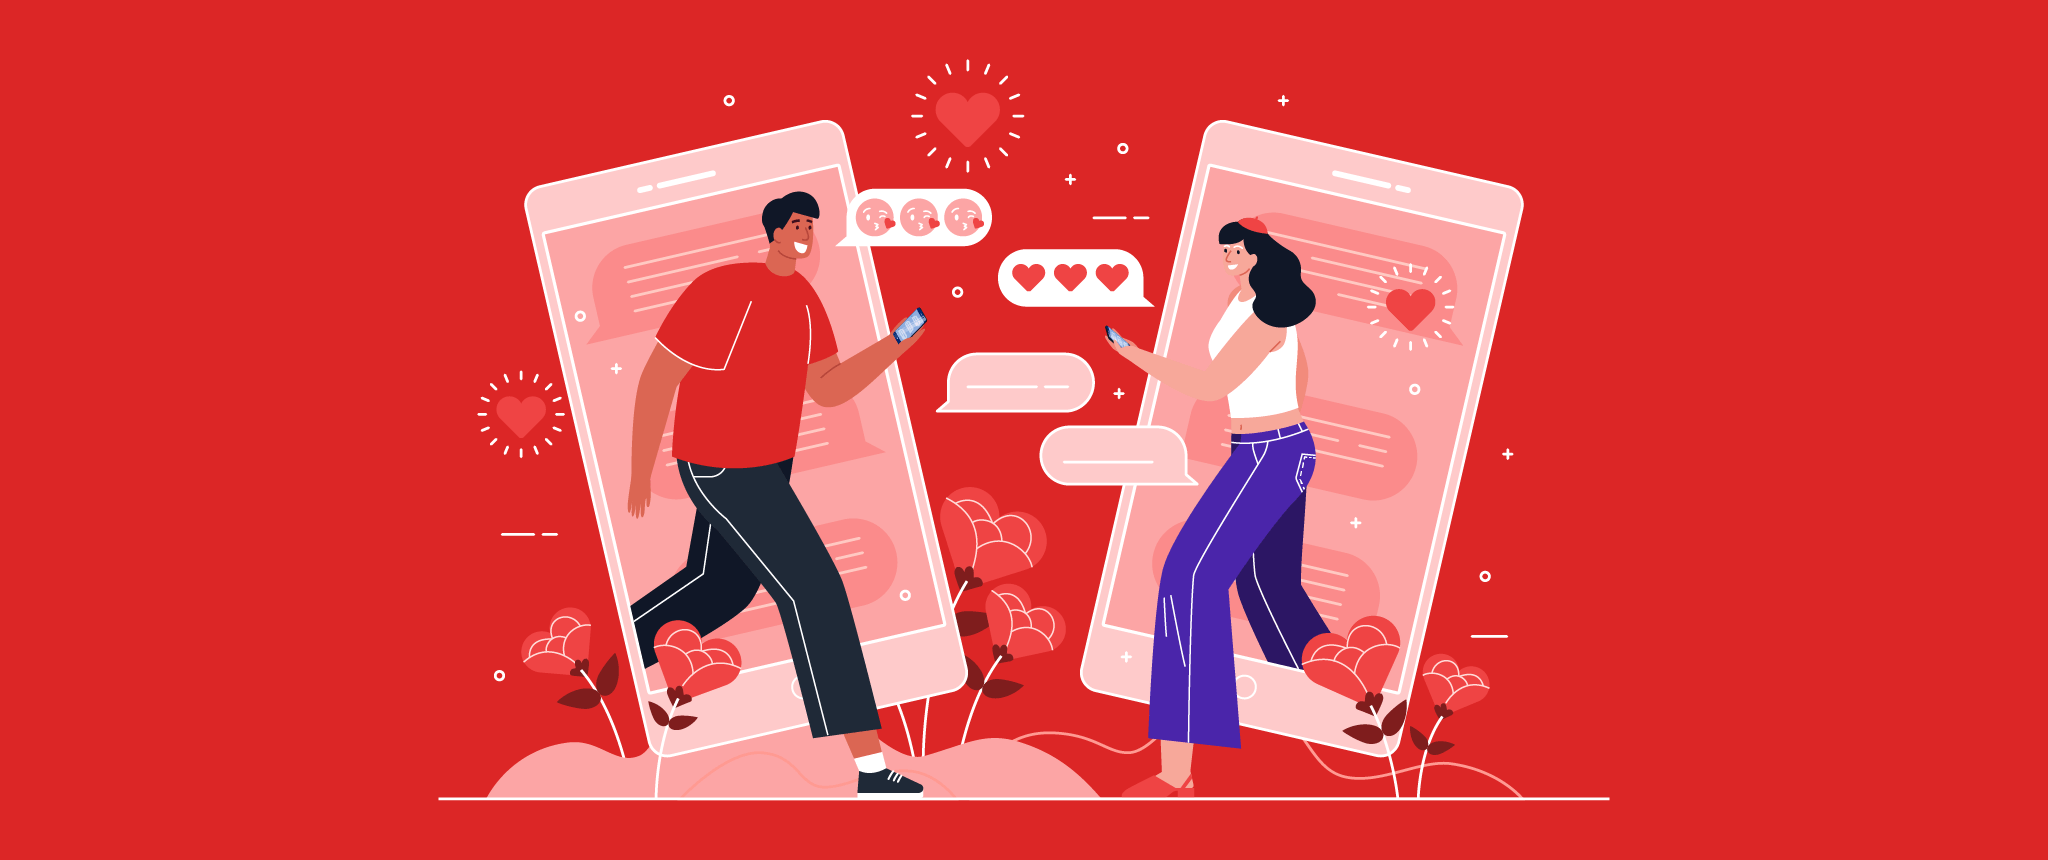

For our customer segmentation in this exercise, we will only take a few features into consideration:
- age 
- sex
- height
- income 
- drugs 
- smokes 

There are other creative features such as body type, but for now we will take basic but crucial ones that constitute the characters of OKCupid users.

One more, condition that we will consider beforehand is - only users who are SINGLE! 

Reference: https://www.kaggle.com/code/niteshyadav3103/customer-segmentation-using-kmeans-hc-dbscan/notebook

## Data upload

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/딥러닝기초

In [ ]:
import pandas as pd

df = pd.read_csv('./okcupid_profiles.csv')

In [ ]:
df.status.unique()

In [ ]:
single_df = df[df['status']=='single']

In [ ]:
single_df.head(2)

In [ ]:
single_df = single_df[['age','sex','height','income','drugs','smokes']]
single_df.head(2)

In [ ]:
single_df.info()

- Age, sex and infome features have no missing values.
- Height has only 3 - we can replace them with average height value, depending on user's gender. 
- Drugs feature has many missing values.
- Smokes feature has some missing values.

In order to replace the missing values of drugs and smokes, maybe it might be helpful to do some data processing and see the correlation between the two features.

In [ ]:
single_df.drugs.value_counts()

In [ ]:
single_df.smokes.value_counts()

We can convert the smokes feature into an ordinal feature. 

- If a user does not smoke at all, it will be 0.
- User smokes occasionally = 1.
- If a user answers as 'yes' = 2. 
- We will change missing values to -1, temporarily. 

## Data Preprocessing

In [ ]:
#mapping smokes feature
def smoker_mapping(x):
  if x == 'no':
    x = 0
  elif x in ('sometimes','when driking','trying to quit'):
    x = 1
  elif x == 'yes':
    x = 2
  else: # if None
    x = -1 

  return x 

In [ ]:
single_df['smokes'] = single_df.smokes.apply(lambda x: smoker_mapping(x))

In [ ]:
single_df.smokes.value_counts()

We can also convert the drugs feature in a similar way! 

In [ ]:
#mapping smokes feature
def drugs_mapping(x):
  if x == 'never':
    x = 0
  elif x == 'sometimes':
    x = 1
  elif x == 'often':
    x = 2
  else: # if None
    x = -1 

  return x 

In [ ]:
single_df['drugs'] = single_df.drugs.apply(lambda x: drugs_mapping(x))

In [ ]:
single_df.drugs.value_counts()

In [ ]:
# If the feature was meant to be a nominal feature, we could just use below code.
'''single_df['drugs']=single_df['drugs'].astype('category').cat.codes'''

Oops, the code abov has turned 'sometimes' value to 2, and 'often' to 1. We want the opposite way. 

In [ ]:
import seaborn as sns 

sns.heatmap(single_df.corr(), annot=True)

There is some kind of positive correlation between smoking and taking drugs. This implies: when you say yes to 'do you smoke?', you are more likely to take drugs often than not taking drugs at all.

Let's look a bit closer.

In [ ]:
import matplotlib.pyplot as plt
 
# count plot on single categorical variable
sns.countplot(x ='drugs', hue = "smokes", data = single_df)
 
# Show the plot
plt.show()

It is now obvious that users who never take drugs,mostly don't smoke at all. 

Looking at the graph, there are only few users who take drugs. 

We can just simply replace the missing values in the 'drugs' feature with 0 (never take drugs), because ...
- the general fact about OKCupid users tells us that users (at least singles) mostly don't do drugs. 
- Users with missing values in the 'drugs' feature, mostly don't smoke. Since smoking and drugs have possible correlation, they are less likely to take drugs.

We will do the same for the 'smokes' feature.

In [ ]:
single_df['drugs'] = single_df['drugs'].replace(-1, 0)
single_df['smokes'] = single_df['smokes'].replace(-1, 0)

In [ ]:
single_df.describe()

You can see in the above table that minimum values of two features are 0, respectively.

In [ ]:
single_df.info()

Now we only have height feature left to fill out the missing values. 

Like mentioned earlier, we will calculate the average height of female/male users  and replace the missing values with the average value.

In [ ]:
single_df.groupby('sex')['height'].mean()

In [ ]:
single_df.loc[(single_df['sex']=='f') & df['height'].isna(), 'height'] = 65.1
single_df.loc[(single_df['sex']=='m') & df['height'].isna(), 'height'] = 70.4

In [ ]:
single_df.info()

Let's look at other features, if there is no odd values, by looking at each distribution.

In [ ]:
display(single_df.age.describe())
sns.distplot(single_df.age)

110 years old...? No way..! I mean love has no age limit.. But let's just remove it for our exercise ;)

In [ ]:
q_hi  = single_df["age"].quantile(0.99)

single_df = single_df[(single_df["age"] < q_hi)]
single_df.head(2)

In [ ]:
display(single_df.height.describe())
sns.distplot(single_df.height)

Looking at the distribution of height feature, we can find out that users are mostly between 160 and 180 meters high. 

This can be regarded as normal distribution, when we remove the outliers such as those with minimum value of 1 or maximum value of 100. 

The upper quantile gives us 76. But let's just change this manually to 90, because heights around 180cm are not very much like outliers. 

In [ ]:
q_low = single_df["height"].quantile(0.01)
q_hi  = single_df["height"].quantile(0.99)

print(q_low,q_hi)

new_q_hi = q_hi+14

print(q_low,new_q_hi)

single_df = single_df[(single_df["height"] < q_hi) & (single_df["height"] > q_low)]
single_df.head(2)

In [ ]:
display(single_df.income.describe())
sns.distplot(single_df.income)

In the income feature, we can clearly see that there is also an outlier. Moreover it does not make sense that the income is a negative value (-1). This might refer to missing values. 

The distribution is heavily right-skewed. 

It will still be right-skewed without the outlier, but we can apply log2 to make it more like normal distribution. 

Thus, we will do two steps:
1. Remove (upper!) outliers
2. Replace missing values with the average income.

In [ ]:
single_df["income"].value_counts()

Wait... 

we thought the income feature has diverse income values in its interval. However, the value_counts above tells us that it has only couples of unique income values(!)

Maybe it might be a better idea to either categorize these values into 'income classes' or just leave them, rather than removing outliers. This might gives us better results than without outliers (If there are many so called 'outliers', this also means reducing the amount of information.)

We need to change our plans:
1. Replace missing values with the average income.
2. Categorize into income classes or leave them -> We will take the latter option.

In [ ]:
'''upper_outliers = single_df["income"].quantile(0.99)
single_df[single_df["income"] > upper_outliers].income.value_counts()

single_df = single_df[single_df["income"] < upper_outliers]
single_df.head(2)
'''

In [ ]:
average_income = single_df['income'].mean()
single_df['income'] = single_df['income'].replace(-1,average_income)

In [ ]:
single_df['income'].describe()

Hhmm... It seems like we are now more or less ready for the user segmentation :)

In [ ]:
sns.heatmap(single_df.corr(), annot=True)

In [ ]:
single_df['sex']=single_df['sex'].astype('category').cat.codes

## Feature relevance

In [ ]:
# Source code from https://github.com/sushantdhumak/Creating-Customer-Segments/blob/master/Customer_Segments.ipynb
# Importing required libraries

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

# Creating a list of features

features = list(single_df.columns)

# Using loop to go through every the feature in feature list

for feature in features:
    
    # Making a copy of the DataFrame, using the 'drop' function to drop the given feature
    
    new_data = single_df.drop([feature], axis = 1)

    # Splitting the data into training and testing sets(0.25) using the given feature as the target
    # Setting a random state.

    X_train, X_test, y_train, y_test = train_test_split(new_data, single_df[feature], test_size=0.25, random_state=42)

    # Creating a decision tree regressor and fit it to the training set

    regressor = DecisionTreeRegressor(random_state=63)
    regressor.fit(X_train, y_train)

    # Reporting the score of the prediction using the testing set
    
    from sklearn.metrics import r2_score
    
    score = r2_score(y_test, regressor.predict(X_test))
    
    print('R2 Score after removing {} : {}'.format(feature, score))

We will shortly look at each distribution of the features in our new dataset.

In [ ]:
sns.pairplot(single_df)

## 🧩 Clustering methods

In [ ]:
single_df.reset_index(inplace=True, drop=True )
single_df.head()

We will scale our dataset, before experimenting with three different clusting algorithms.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()                                         
df_scaled = scaler.fit_transform(single_df)

### K-Means

In [ ]:
from sklearn.cluster import KMeans

wcss_1 = []                                     
range_values = range(1, 11)  # Find out optimal number of clusters between 1 and 10.        

for i in range_values:                        
  kmeans = KMeans(n_clusters=i, init = 'k-means++')                 
  kmeans.fit(df_scaled)            
  wcss_1.append(kmeans.inertia_)  

> What is wcss? 

WCSS is the sum of squared distance between each point and the centroid in a cluster. When we plot the WCSS with the K value, the plot looks like an Elbow. As the number of clusters increases, the WCSS value will start to decrease. WCSS value is largest when K = 1.

In [ ]:
plt.figure(figsize = (12, 7))

plt.plot(range(1, 11), wcss_1, linewidth = 2, marker = '8')
plt.title('K-Means Elbow Plot\n', fontsize = 20)
plt.xlabel('K')
plt.ylabel('WCSS')
plt.show()

-----

> Difference when using fit_predict() and fit() :

In [ ]:
kmeans = KMeans(n_clusters = 4)
labels = kmeans.fit_predict(df_scaled)
print(labels)

In [ ]:
kmeans = KMeans(n_clusters=4)           
kmeans.fit(df_scaled)         
labels = kmeans.labels_
print(labels)

---

#### Cluster Centroids

Check the feature values of each cluster centers.

- The first cluster_centers df with scaled feature values. ⬇️

In [ ]:
cluster_centers = pd.DataFrame(data = kmeans.cluster_centers_, columns = [single_df.columns])
cluster_centers

- The second cluster_centers df with orginal feature values (scale inversed)
⬇️

In [ ]:
cluster_centers = scaler.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(data = cluster_centers, columns = [single_df.columns])
cluster_centers

Match each datapoint with classified cluster number.

In [ ]:
df_mk_cluster = pd.concat([single_df, pd.DataFrame({'cluster': labels})], axis = 1) 
df_mk_cluster.head()

#### 3D Plot with plotly

In [ ]:
import plotly.express as px

fig = px.scatter_3d(df_mk_cluster, x="income", y="age", z="drugs",
                    color = 'cluster', size = 'cluster')
fig.show()

With K-Means it seems that datapoints are not clearly clustered well.

## PCA

Using PCA we can reduce the dimenstion of our  scaled dataset.

In [ ]:
df_scaled

We will reduce the dimension from 6 into half.

In [ ]:
scaled_df = pd.DataFrame(df_scaled,columns=single_df.columns) 
scaled_df.head()

In [ ]:
from sklearn.decomposition import PCA

pca=PCA(n_components=3)

pca.fit(scaled_df)
result_pca = pca.transform(scaled_df)
print(result_pca.shape)

In [ ]:
print(pca.explained_variance_ratio_)
sum(pca.explained_variance_ratio_)

The new dimension can only explains 67% of the total information.

In [ ]:
pca_columns = ['pca_component1','pca_component2','pca_component3']
df_pca = pd.DataFrame(result_pca,columns=pca_columns)
df_pca.head()

Let's try K-Means again with the new dataset.

In [ ]:
from sklearn.cluster import KMeans

wcss_1 = []                                     
range_values = range(1, 11)  # Find out optimal number of clusters between 1 and 10.        

for i in range_values:                        
  kmeans = KMeans(n_clusters=i, init = 'k-means++')                 
  kmeans.fit(df_pca)            
  wcss_1.append(kmeans.inertia_)  

In [ ]:
plt.figure(figsize = (12, 7))

plt.plot(range(1, 11), wcss_1, linewidth = 2, marker = '8')
plt.title('K-Means Elbow Plot\n (Lower dimension)', fontsize = 20)
plt.xlabel('K')
plt.ylabel('WCSS')
plt.show()

K=3 looks good!

In [ ]:
kmeans = KMeans(n_clusters=3)           
kmeans.fit(df_pca)         
labels = kmeans.labels_
print(labels)

In [ ]:
cluster_centers = pd.DataFrame(data = kmeans.cluster_centers_)
cluster_centers

In [ ]:
df_pca['cluster'] = kmeans.labels_

In [ ]:
df_pca.head()

In [ ]:
single_df1 = single_df.copy()
single_df1['cluster'] = kmeans.labels_

In [ ]:
single_df1.groupby('cluster').mean()

In [ ]:
fig = px.scatter_3d(df_pca, x="pca_component1", y="pca_component2", z="pca_component3",
                    color = 'cluster', size = 'cluster')
fig.show()

### Hierarchical Clustering

Hierarchical clustering is a popular method for grouping objects. It creates groups so that objects within a group are similar to each other and different from objects in other groups. Clusters are visually represented in a hierarchical tree called a dendrogram.

In [ ]:
'''from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

plt.figure(figsize = (17, 8))

dendo = dendrogram(linkage(df_scaled, method = 'ward'))
plt.title('Dendrogram', fontsize = 15)
plt.show()'''

In [ ]:
'''from sklearn.cluster import AgglomerativeClustering

agc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
labels = agc.fit_predict(df_scaled)'''

This eats too much RAM, we will skip this part.

## DBSCAN

DBSCAN (Density-Based Spatial Clustering of Application with Noise)

노이즈가 있는 대규모 데이터에 적용할 수 있는 밀도 기반의 군집화

레퍼런스 : https://pizzathief.oopy.io/dbscan

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
db = DBSCAN(eps=0.95, min_samples=10).fit(df_pca)

labels = db.labels_

In [ ]:
# Number of clusters in labels, ignoring noise if present.

# the label -1 is considered as noise by the DBSCAN algorithm
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0) 
n_noise_ = list(labels).count(-1)  # calculating the number of clusters

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

"""Homogeneity metric of a cluster labeling given a ground truth.

A clustering result satisfies homogeneity if all of its clusters
contain only data points which are members of a single class."""

#print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))

In [ ]:
df_pca['cluster_DBSCAN'] = labels

In [ ]:
df_pca.head()

In [ ]:
df_pca.cluster_DBSCAN.value_counts()

In [ ]:
df_pca['cluster_DBSCAN'] = df_pca['cluster_DBSCAN'].replace(-1,5)

In [ ]:
fig = px.scatter_3d(df_pca, x="pca_component1", y="pca_component2", z="pca_component3",
                    color = 'cluster_DBSCAN', size = 'cluster_DBSCAN')
fig.show()

In [ ]:
single_dfDBSCAN = single_df.copy()
single_dfDBSCAN['cluster'] = labels

In [ ]:
single_dfDBSCAN.groupby('cluster').mean()